# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import chain
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from functools import partial

# Setting a seed for random stuff
seed = 54321

# Read the data 

Here the dataset will be a spam classification dataset. The dataset is available at

In [2]:
inputs = []
targets = []
with open("SMSSpamCollection", "r") as f:
    for row in f:
        inputs += [row.split()[1:]]
        targets += row.split()[:1]


inputs = pd.Series(inputs)
targets = pd.Series(targets).map({'spam':1, 'ham':0})

n_samples = 5
for inp, tgt in zip(inputs[:5], targets[:5]):
    print(inp)
    print(tgt)
    print("\n")

['Go', 'until', 'jurong', 'point,', 'crazy..', 'Available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'Cine', 'there', 'got', 'amore', 'wat...']
0


['Ok', 'lar...', 'Joking', 'wif', 'u', 'oni...']
0


['Free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'FA', 'Cup', 'final', 'tkts', '21st', 'May', '2005.', 'Text', 'FA', 'to', '87121', 'to', 'receive', 'entry', 'question(std', 'txt', "rate)T&C's", 'apply', "08452810075over18's"]
1


['U', 'dun', 'say', 'so', 'early', 'hor...', 'U', 'c', 'already', 'then', 'say...']
0


['Nah', 'I', "don't", 'think', 'he', 'goes', 'to', 'usf,', 'he', 'lives', 'around', 'here', 'though']
0




# Splitting training and test data

In [3]:
# Shuffle the data
df = pd.DataFrame({'text': inputs, 'label': targets}).sample(frac=1.0, random_state=seed)

n = 500 # Number of samples for each label to generate the test set 

# Positive and negative indices of the original dataframe randomly sampled
pos_inds = df[(df["label"]==1)].sample(n=n, random_state=seed).index
neg_inds = df[(df["label"]==0)].sample(n=n, random_state=seed).index

print(pos_inds.shape, neg_inds.shape)
# Get the data with indices
pos_test_samples = df.loc[pos_inds]
neg_test_samples = df.loc[neg_inds]

# Create the test dataset
test_samples = pd.concat([pos_test_samples, neg_test_samples]).sample(frac=1.0, random_state=seed)
print(test_samples.shape)

# Separate inputs and targets
test_inputs, test_labels = test_samples["text"], test_samples["label"]

# Training data
train_samples = df.loc[~df.index.isin(test_samples.index)]
train_inputs, train_labels = train_samples["text"], train_samples["label"]

print("Train dataset size: {}".format(train_inputs.shape))
print(train_labels.value_counts())
print("Test dataset size: {}".format(test_inputs.shape))
print(test_labels.value_counts())

assert test_labels.sum() + train_labels.sum() == df["label"].sum()
# Get the most common 1000 words
n_vocab = 1000
cnt = Counter(chain(*train_inputs.to_list()))
words, _ = zip(*cnt.most_common(n_vocab))


(500,) (500,)
(1000, 2)
Train dataset size: (4574,)
0    4327
1     247
Name: label, dtype: int64
Test dataset size: (1000,)
1    500
0    500
Name: label, dtype: int64


# Print class imbalance in training data

In [4]:
print((1-(train_labels.value_counts()/train_labels.shape[0])).to_dict())

{0: 0.054000874508089214, 1: 0.9459991254919108}


# Creating n-grams with sentences

Here we do a few things.
* Create n-grams E.g. `"abc de f"` will be converted to `["a", "b", "c", ..., "ab", "bc", "c ", " d", ..., "abc", "bc ", "c d", ...]`, create a bag-of-words vector with the found n-grams
* Pad the sentences to a fixed length (and truncate longer ones)

In [5]:
# Define a count vectorizer that will create bag-of-words n-gram vectors
count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,3))
# Fit the count vectorizer on the limited vocabulary to learn ngrams
count_vectorizer.fit(words)

def get_transformed_input(inputs, count_vectorizer, max_seq_length=15):
    """ Get the transformed input by adding empty spaces until the defined length is reached """
    transformed_inputs = []
    
    # For each input, tokenizer it and pad/truncate it
    for inp in inputs:
        if len(inp)<max_seq_length:
            inp = inp + ['']*(max_seq_length-len(inp))
        elif len(inp) > max_seq_length:
            inp = inp[:max_seq_length]
        
        # Get the output transformed by the count vectorizer
        out = count_vectorizer.transform(inp)
        transformed_inputs.append(out.toarray())
    
    transformed_inputs = np.stack(transformed_inputs, axis=0)
    
    return transformed_inputs

# Get preprocessed train data
train_transformed_input = get_transformed_input(train_inputs, count_vectorizer)
print("Transformed train set shape: {}".format(train_transformed_input.shape))
# Get preprocessed test data
test_transformed_input = get_transformed_input(test_inputs, count_vectorizer)
print("Transformed test set shape: {}".format(test_transformed_input.shape))

# Get n-grams learnt
feature_names = count_vectorizer.get_feature_names()
print("# of n-grams learnt: {}".format(len(feature_names)))
n_gram_count = len(feature_names)

Transformed train set shape: (4574, 15, 1499)
Transformed test set shape: (1000, 15, 1499)
# of n-grams learnt: 1499


# Understanding core concepts of angular LSH

## Simplified angular LSH

In [8]:
bins = 32

R = np.random.normal(size=(n_gram_count, bins//2))

ngram_out = count_vectorizer.transform(["now", "Now", "now!", "today", "jungle"]).toarray()
print("ngram_out.shape = {}".format(ngram_out.shape))

h_x = np.dot(ngram_out, R)
print("h_x.shape = {}".format(h_x.shape))

hash_bins = np.argmax(np.concatenate([h_x, -h_x], axis=-1), axis=-1)
print("Hash bins for the words are: {}".format(hash_bins))

ngram_out.shape = (5, 1499)
h_x.shape = (5, 16)
Hash bins for the words are: [19 19  7 10 13]


## What multiplying with a random matrix does?

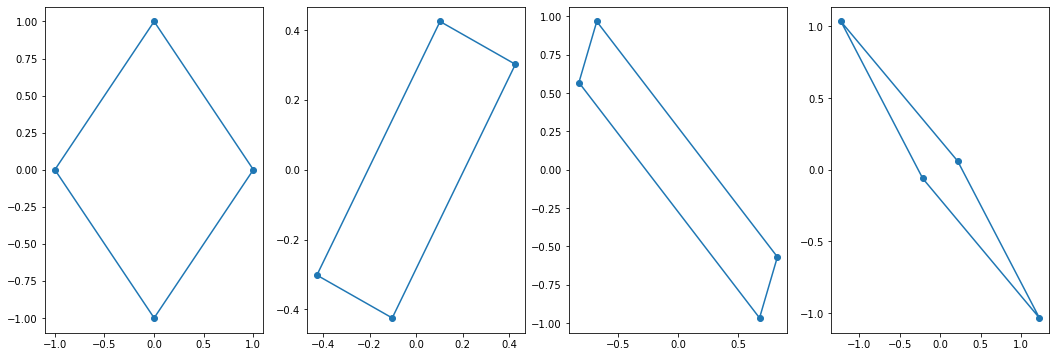

In [9]:
import matplotlib.pyplot as plt

x = np.eye(2)
x_concat = np.concatenate([x, -x], axis=0)


n_col = 4
f, ax = plt.subplots(1, n_col, figsize=(18, 6))


# Plot the original shape
ax[0].scatter(x_concat[:, 0], x_concat[:, 1])
x_concat_looped = np.concatenate([x_concat, x_concat[:1, :]], axis=0)
ax[0].plot(x_concat_looped[:, 0], x_concat_looped[:, 1])

# Plot the roated shapes
for i in range(1, n_col):
    # Random matrix
    R = np.random.normal(size=(2,2))
    # Compute the rotated shape
    x_rotated = np.concatenate([np.dot(x, R), -np.dot(x, R)], axis=0)
    ax[i].scatter(x_rotated[:, 0], x_rotated[:, 1])
    x_rotated_looped = np.concatenate([x_rotated, x_rotated[:1, :]], axis=0)
    ax[i].plot(x_rotated_looped[:, 0], x_rotated_looped[:, 1])

## Solving LSH for batches of data

In [10]:
n_hashes = 8
bins = 32
      
R = np.random.normal(size=(n_gram_count, bins//2))

ngram_out = count_vectorizer.transform(words).toarray()
print("ngram_out.shape = {}".format(ngram_out.shape))

ngram_out = np.expand_dims(ngram_out, axis=0)
h_x = np.einsum('bij,jk-> bik', ngram_out, R)

print("x.shape = {}".format(h_x.shape))
# [batch dim, n_hashes, n_words]
hash_vectors = np.concatenate([h_x, -h_x], axis=-1)
print("hash_vectors.shape = {}".format(hash_vectors.shape))    

ngram_out.shape = (1000, 1499)
x.shape = (1, 1000, 16)
hash_vectors.shape = (1, 1000, 32)


## Normalize to unit length

In [12]:
hash_vectors = hash_vectors[0, :, : ]
hash_vectors = hash_vectors / np.sqrt((hash_vectors**2).sum(axis=-1, keepdims=True))

## Viola: Hash based word vectors

In [14]:
hash_vectors

array([[-0.07948216, -0.33609311,  0.055078  , ...,  0.30802478,
        -0.0009694 ,  0.09367518],
       [ 0.2471338 , -0.03743002,  0.1633045 , ..., -0.22238207,
        -0.12305291,  0.23982288],
       [ 0.19949263, -0.06684852,  0.17171195, ..., -0.014189  ,
        -0.10886495, -0.16658812],
       ...,
       [-0.06592873,  0.0206297 ,  0.05058767, ..., -0.10348268,
         0.01775267,  0.22968855],
       [ 0.20199489, -0.30003315,  0.38968299, ...,  0.11303859,
        -0.22539498, -0.11176935],
       [ 0.27520796,  0.02176   ,  0.2149093 , ...,  0.16082362,
        -0.28286107, -0.19985599]])

# How do they perform?

## Visualizing vectors via T-SNE

In [15]:
vecs_embedded = TSNE(
    n_components=2, init='random', metric='cosine'
).fit_transform(hash_vectors.astype('float32'))

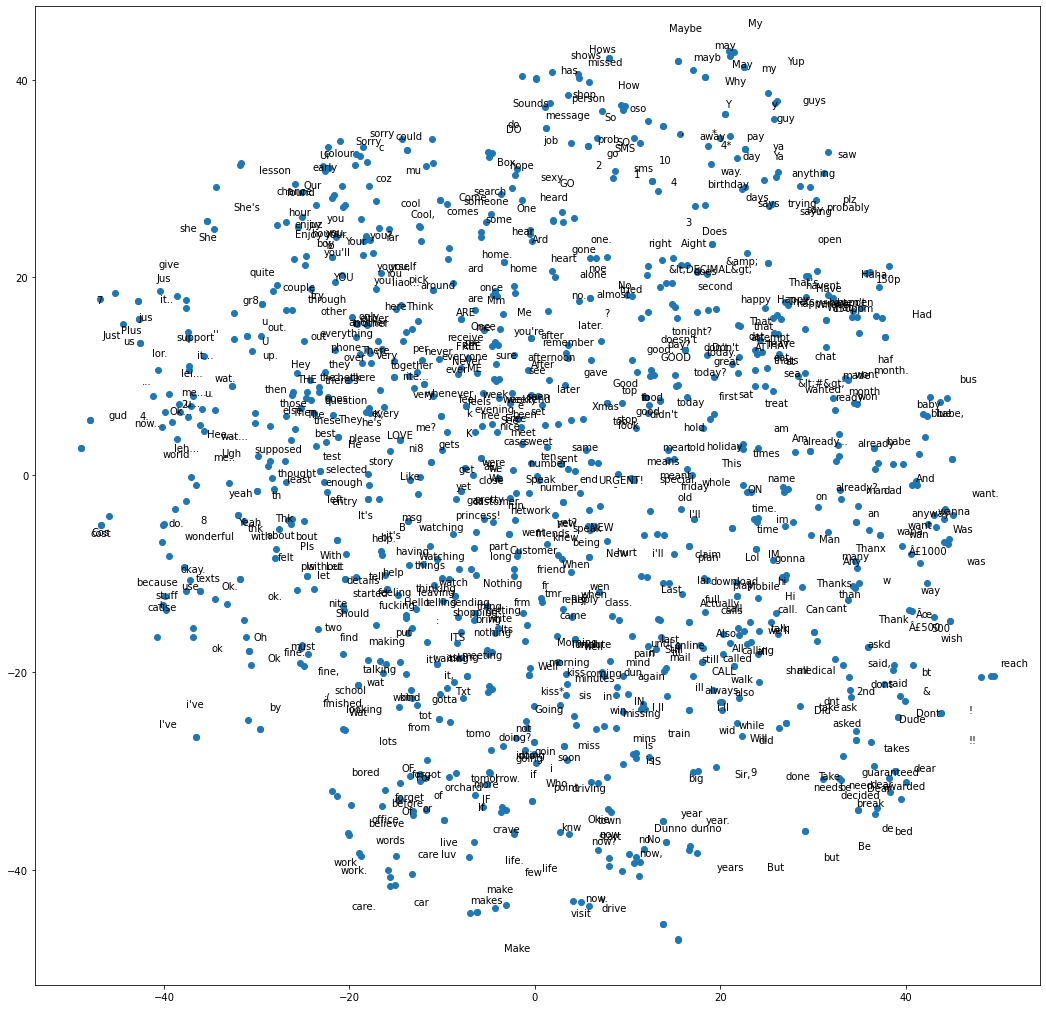

In [16]:
f, ax = plt.subplots(1, 1, figsize=(18,18))
ax.scatter(vecs_embedded[:,0], vecs_embedded[:,1])

for i, txt in enumerate(words):
    if np.random.normal()<0.5:
        ax.annotate(txt, (vecs_embedded[i,0]+np.random.randint(-4, 4), vecs_embedded[i,1]+np.random.randint(-4, 4)))

## Print similar words

Some interesting examples. Remember that the `CountVectorizer` turns words to lower-case for us.

```
Love ['LOVE', 'love', 'their', 'Well', 'well']
My ['my', 'MY', 'T&Cs', 'Â£1.50', 'price']
ARE ['Are', 'ARE', 're', 'remember', 'care']
Call ['Call', 'call', 'CALL', "I'll", "i'll"]
```

In [25]:
k = 5
sort_ids = np.argsort(-np.dot(hash_vectors, hash_vectors.T), axis=-1)[:, 1:k+1]

probe_ids = np.random.randint(1000, size=10)

for pid in probe_ids:
    
    print(words[pid], [words[sid] for sid in sort_ids[pid]])

And ['and', 'AND', 'an', 'dnt', 'sad']
job ['go', 'GO', "that's", "That's", 'Hope']
talk ['called', 'talking', 'medical', "we'll", 'call']
3 ['day.', 'sat', 'today.', 'dat', 'neva']
Oh ['drop', 'Think', 'think', 'oh.', 'through']
since ['princess!', 'Well', 'well', 'minute', 'We']
do. ['used', 'okay.', 'does', 'Does', '2.']
these ['the', 'The', 'THE', 'Then', 'then']
Yar ['Cool,', 'class', 'cool', 'lar', 'Sorry,']
supposed ['those', 'used', 'support', 'else', 'message']


# Let's use this in a model!

In [26]:
tf.keras.backend.clear_session()

class Hash2Vec(tf.keras.layers.Layer):
    
    def __init__(self, hash_bins):
        """ Initialize the random matrix """
        # A matrix of size [number of hashes, feature dim, number of bins]
        self.R = None
        self.hash_bins = hash_bins
        
        super().__init__()
    
    def build(self, input_shape):
        # [b, seq, ngrams]
        self.R = self.add_weight(
            shape=(input_shape[-1], self.hash_bins//2),
            initializer='random_normal',
            trainable=False
        )

        
    def call(self, x):
        """ The actual computation of the hash vectors """
        # x - [batch size, sequence leng, feature dim]
        # out - [batch size, number of hashes, seqeuence length, number of bins]
        batch_h_x = tf.einsum('bij,jk->bik', x, self.R)

        # out - [batch size, n_hashes, sequence len]
        #batch_closest_neighbor = tf.cast(tf.transpose(tf.argmax(batch_hashed_x, axis=-1), [0, 2, 1]), 'float32')
        batch_concat_h_x = tf.concat([batch_h_x, - batch_h_x], axis=-1)
        # Normalize the vectors
        return tf.math.l2_normalize(batch_concat_h_x, axis=-1)
    
    def get_config(self):
        """ TODO """
        pass

    
seq_length = 15
ngram_dim = len(count_vectorizer.get_feature_names())
bins = 64


def get_hash2vec_classifier(seq_length, ngram_dim, bins):
    # Defining the model

    # Defining input layer
    ngram_input = tf.keras.layers.Input(shape=(seq_length, ngram_dim))
    # Define the hash2vec layer
    hash2vec_out = Hash2Vec(bins)(ngram_input)
    # Define a layer to flatten the time dimension and create a long vector containing outputs of all steps
    concat_out = tf.keras.layers.Flatten()(hash2vec_out)
    # Final layer
    dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(concat_out)


    # Define the final model and compile it
    model = tf.keras.models.Model(inputs=ngram_input, outputs=dense_out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    
    return model

model = get_hash2vec_classifier(seq_length, ngram_dim, bins)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1499)]        0         
_________________________________________________________________
hash2_vec (Hash2Vec)         (None, 15, 64)            47968     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 961       
Total params: 48,929
Trainable params: 961
Non-trainable params: 47,968
_________________________________________________________________


# Training the model

In [27]:
def train_and_test_model(model_func, train_x, train_y, test_x, test_y, n_trials=10):
    
    results = []
    
    for trial in range(n_trials):
        print("Training model for trial {}".format(trial))
        trial_results = {}
        
        model = model_func()

        history = model.fit(
            train_x, 
            train_y, 
            class_weight=(1-(train_y.value_counts()/train_y.shape[0])).to_dict(),
            epochs=10, 
            batch_size=128,
            verbose=0
        )
        trial_results["train_accuracy"] = history.history['accuracy']
        
        out = model.evaluate(test_x, test_y, return_dict=True)
        trial_results["test_accuracy"] = out['accuracy']
        
        print("\tTest accuracy: {}".format(out['accuracy']))
        
        results.append(trial_results)
    print('\nDone')
    
    return results

get_hash2vec_classifier_partial = partial(get_hash2vec_classifier, seq_length=seq_length, ngram_dim=ngram_dim, bins=bins)
hash2vec_results = train_and_test_model(
    get_hash2vec_classifier_partial, train_transformed_input, train_labels, test_transformed_input, test_labels)

Training model for trial 0
32/32 [==============================] - 0s 4ms/step - loss: 0.4857 - accuracy: 0.8310
	Test accuracy: 0.8309999704360962
Training model for trial 1
32/32 [==============================] - 0s 4ms/step - loss: 0.4958 - accuracy: 0.8370
	Test accuracy: 0.8370000123977661
Training model for trial 2
32/32 [==============================] - 0s 3ms/step - loss: 0.5063 - accuracy: 0.8000
	Test accuracy: 0.800000011920929
Training model for trial 3
32/32 [==============================] - 0s 4ms/step - loss: 0.4791 - accuracy: 0.8220
	Test accuracy: 0.8220000267028809
Training model for trial 4
32/32 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.7980
	Test accuracy: 0.7979999780654907
Training model for trial 5
32/32 [==============================] - 0s 4ms/step - loss: 0.4923 - accuracy: 0.8170
	Test accuracy: 0.8169999718666077
Training model for trial 6
32/32 [==============================] - 0s 4ms/step - loss: 0.4756 - accuracy: 

# Comparing to bag-of-words vectors

In [28]:
def get_bag_of_ngrams_classifier():
    
    tf.keras.backend.clear_session()

    # Defining input layer
    ngram_input = tf.keras.layers.Input(shape=(seq_length, ngram_dim))

    # Define a layer to flatten the time dimension and create a long vector containing outputs of all steps
    summed_out = tf.keras.layers.Flatten()(ngram_input)
    # Dense hidden layer
    dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(summed_out)

    # Define the final model and compile it
    model = tf.keras.models.Model(inputs=ngram_input, outputs=dense_out)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    
    return model

model = get_bag_of_ngrams_classifier()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 1499)]        0         
_________________________________________________________________
flatten (Flatten)            (None, 22485)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 22486     
Total params: 22,486
Trainable params: 22,486
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bon_results = train_and_test_model(get_bag_of_ngrams_classifier, train_transformed_input, train_labels, test_transformed_input, test_labels)

Training model for trial 0
32/32 [==============================] - 0s 3ms/step - loss: 0.3597 - accuracy: 0.8390
	Test accuracy: 0.8389999866485596
Training model for trial 1
32/32 [==============================] - 0s 3ms/step - loss: 0.3636 - accuracy: 0.8380
	Test accuracy: 0.8379999995231628
Training model for trial 2
32/32 [==============================] - 0s 3ms/step - loss: 0.3629 - accuracy: 0.8370
	Test accuracy: 0.8370000123977661
Training model for trial 3
32/32 [==============================] - 0s 3ms/step - loss: 0.3578 - accuracy: 0.8410
	Test accuracy: 0.8410000205039978
Training model for trial 4
32/32 [==============================] - 0s 3ms/step - loss: 0.3569 - accuracy: 0.8360
	Test accuracy: 0.8360000252723694
Training model for trial 5
32/32 [==============================] - 0s 3ms/step - loss: 0.3564 - accuracy: 0.8420
	Test accuracy: 0.8420000076293945
Training model for trial 6
32/32 [==============================] - 0s 3ms/step - loss: 0.3541 - accuracy:

# Comparing to trainable word vectors

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='',
    lower=False, oov_token='UNK'
)


train_sentences = [' '.join(msg) for msg in train_inputs]
print(len(train_sentences))
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
pad_train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    train_sequences, maxlen=15, dtype='int32', padding='post',
    truncating='post', value=0.0
)
test_sentences = [' '.join(msg) for msg in test_inputs]
test_sequences = tokenizer.texts_to_sequences(test_sentences)
pad_test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    test_sequences, maxlen=15, dtype='int32', padding='post',
    truncating='post', value=0.0
)


In [ ]:
import tensorflow as tf
import numpy as np

tf.keras.backend.clear_session()

    
seq_length = 15
emb_dim = 64

def get_word2vec_classifier(vocab_size, seq_length, emb_dim):
    
    ngram_input = tf.keras.layers.Input(shape=(seq_length,))
    emb_out = tf.keras.layers.Embedding(vocab_size, emb_dim)(ngram_input)
    concat_out = tf.keras.layers.Flatten()(emb_out)
    dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(concat_out)

    model = tf.keras.models.Model(inputs=ngram_input, outputs=dense_out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    
    return model

model = get_word2vec_classifier(1001, seq_length, emb_dim=emb_dim)
model.summary()

In [ ]:
get_word2vec_classifier_partial = partial(get_word2vec_classifier, vocab_size=1001, seq_length=seq_length, emb_dim=emb_dim)

word2vec_results = train_and_test_model(
    get_word2vec_classifier_partial, 
    pad_train_sequences, 
    train_labels, 
    pad_test_sequences, 
    test_labels
)

# Print final results

In [ ]:
hash2vec_test_accuracies = [dct["test_accuracy"] for dct in hash2vec_results]
bon_test_accuracies = [dct["test_accuracy"] for dct in bon_results]
word2vec_test_accuracies = [dct["test_accuracy"] for dct in word2vec_results]

print("Hash2vec: {} (mean) / {} (std)".format(
    np.array(hash2vec_test_accuracies).mean(),
    np.array(hash2vec_test_accuracies).std()
))
print("Bag-of-ngrams: {} (mean) / {} (std)".format(
    np.array(bon_test_accuracies).mean(),
    np.array(bon_test_accuracies).std()
))
print("Word2vec: {} (mean) / {} (std)".format(
    np.array(word2vec_test_accuracies).mean(),
    np.array(word2vec_test_accuracies).std()
))